In [81]:
from utils.datasets import get_data, base_novel_categories, split_data
import clip
import torch
clip_model, preprocess = clip.load("RN50")

train_set, val_set, test_set = get_data(data_dir="../cifar10", transform=preprocess)

# split classes into base and novel
base_classes, novel_classes = base_novel_categories(train_set)

# split the three datasets
train_base, _ = split_data(train_set, base_classes)


In [82]:
device = "mps" if torch.backends.mps.is_available() else "cuda" if torch.cuda.is_available() else "cpu"
clip_model = clip_model.to(device)


In [83]:
import numpy as np
class_feature = {}
with torch.no_grad():
    for c in base_classes:
        imgs_c = [img for img, label in train_base if label == c]
        features = [clip_model.encode_image(img.unsqueeze(0).to(device)).cpu().numpy() for img in imgs_c]
        class_feature[c] = np.mean(features, axis=0)

Class 0: 10 images


/var/folders/q6/bw_h2w9d6js7mn__0srnx8rm0000gn/T/ipykernel_4991/2827597755.py:8: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/torch/csrc/utils/tensor_new.cpp:257.)
  print(f"features shape: {torch.tensor(features).shape}")


features shape: torch.Size([10, 1, 1024])
Class 1: 10 images
features shape: torch.Size([10, 1, 1024])
Class 2: 10 images
features shape: torch.Size([10, 1, 1024])
Class 3: 10 images
features shape: torch.Size([10, 1, 1024])
Class 4: 10 images
features shape: torch.Size([10, 1, 1024])
Class 5: 10 images
features shape: torch.Size([10, 1, 1024])
Class 6: 10 images
features shape: torch.Size([10, 1, 1024])
Class 7: 10 images
features shape: torch.Size([10, 1, 1024])
Class 8: 10 images
features shape: torch.Size([10, 1, 1024])
Class 9: 10 images
features shape: torch.Size([10, 1, 1024])
Class 10: 10 images
features shape: torch.Size([10, 1, 1024])
Class 11: 10 images
features shape: torch.Size([10, 1, 1024])
Class 12: 10 images
features shape: torch.Size([10, 1, 1024])
Class 13: 10 images
features shape: torch.Size([10, 1, 1024])
Class 14: 10 images
features shape: torch.Size([10, 1, 1024])
Class 15: 10 images
features shape: torch.Size([10, 1, 1024])
Class 16: 10 images
features shape: t

In [84]:
class_feature[0].shape

(1, 1024)

In [96]:
class_ft_array = np.array([class_feature[c][0] for c in base_classes])
class_ft_array.shape

(51, 1024)

In [97]:
from sklearn.decomposition import PCA

pca = PCA(n_components=0.95)  # Keep 95% of variance
X_reduced = pca.fit_transform(class_ft_array)
X_reduced.shape

(51, 29)

In [98]:
from sklearn.cluster import KMeans

n_clusters = 2  # or more if needed

kmeans = KMeans(n_clusters=n_clusters, random_state=42)
cluster_labels = kmeans.fit_predict(X_reduced)  # shape: [n_base_classes]

In [75]:
cluster_labels

array([0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0, 0, 0, 0, 1,
       1, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0,
       0, 0, 1, 1, 1, 1, 0], dtype=int32)

In [99]:
from utils.datasets import CLASS_NAMES
cluster_labels_text = {
    CLASS_NAMES[base_class]: int(cluster) for base_class, cluster in enumerate(cluster_labels)
}
cluster_labels_text

{'pink primrose': 0,
 'hard-leaved pocket orchid': 0,
 'canterbury bells': 0,
 'sweet pea': 0,
 'english marigold': 1,
 'tiger lily': 0,
 'moon orchid': 0,
 'bird of paradise': 0,
 'monkshood': 0,
 'globe thistle': 1,
 'snapdragon': 0,
 "colt's foot": 1,
 'king protea': 1,
 'spear thistle': 1,
 'yellow iris': 0,
 'globe-flower': 0,
 'purple coneflower': 1,
 'peruvian lily': 0,
 'balloon flower': 0,
 'giant white arum lily': 0,
 'fire lily': 0,
 'pincushion flower': 1,
 'fritillary': 1,
 'red ginger': 0,
 'grape hyacinth': 1,
 'corn poppy': 0,
 'prince of wales feathers': 1,
 'stemless gentian': 0,
 'artichoke': 1,
 'sweet william': 0,
 'carnation': 0,
 'garden phlox': 0,
 'love in the mist': 1,
 'mexican aster': 1,
 'alpine sea holly': 1,
 'ruby-lipped cattleya': 0,
 'cape flower': 0,
 'great masterwort': 1,
 'siam tulip': 0,
 'lenten rose': 0,
 'barbeton daisy': 1,
 'daffodil': 0,
 'sword lily': 0,
 'poinsettia': 0,
 'bolero deep blue': 0,
 'wallflower': 0,
 'marigold': 1,
 'buttercup

In [100]:
n_cat_per_cluster = 3
n_photo_per_cat = 5
import random


def get_random_images_from_cluster(cluster_labels, train_set, n_cat_per_cluster, n_photo_per_cat):
    cluster_images = {}
    for cluster in set(cluster_labels.values()):
        cluster_images[cluster] = {}
        categories = [cat for cat, cluster_tmp in cluster_labels_text.items() if cluster_tmp == cluster]
        random.shuffle(categories)
        categories = categories[:n_cat_per_cluster]
        
        for cat in categories:
            cluster_images[cluster][cat] = []
            cat_images = [img for img, label in train_set if label == CLASS_NAMES.index(cat)]
            random.shuffle(cat_images)
            cluster_images[cluster][cat] = cat_images[:n_photo_per_cat]
            
        
    return cluster_images

In [114]:
import matplotlib.pyplot as plt
import numpy as np
import torch

def normalize_image(img):
    """Normalize a float image to [0, 1] if it's outside that range."""
    if img.dtype == np.float32 or img.dtype == np.float64:
        if img.min() < 0 or img.max() > 1:
            img = (img - img.min()) / (img.max() - img.min() + 1e-8)
    return img

def show_images(images, n_cols=5):
    n_rows = int(np.ceil(len(images) / n_cols))
    fig, axes = plt.subplots(n_rows, n_cols, figsize=(15, 3 * n_rows))
    if isinstance(axes, np.ndarray):
        axes = axes.flatten()
    else:
        axes = [axes]
    for i, img in enumerate(images):
        ax = axes[i]
        if isinstance(img, torch.Tensor):  # Convert PyTorch tensor to NumPy
            img = img.detach().cpu().permute(1, 2, 0).numpy()
        img = normalize_image(img)  # Apply normalization
        ax.imshow(img)
        ax.axis("off")
    # Hide unused subplots
    for ax in axes[len(images):]:
        ax.axis("off")
    plt.show()

In [111]:
res = []
for cluster in range(n_clusters):
    print(f"Cluster {cluster}:")
    categories = [cat for cat, cluster_tmp in cluster_labels_text.items() if cluster_tmp == cluster]
    #random.shuffle(categories)
    #categories = categories[:20]
    tmp_dict = {}
    for cat in categories:
        first_image = [image for image, target in train_base if target==CLASS_NAMES.index(cat)]
        random.shuffle(first_image)
        first_image = first_image[0]
        tmp_dict[cat] = first_image
    res.append(tmp_dict)
        
    
   
    

Cluster 0:
Cluster 1:


In [109]:
len([cat for cat, cluster_tmp in cluster_labels_text.items() if cluster_tmp == 0])

31

In [110]:
len([cat for cat, cluster_tmp in cluster_labels_text.items() if cluster_tmp == 1])

20

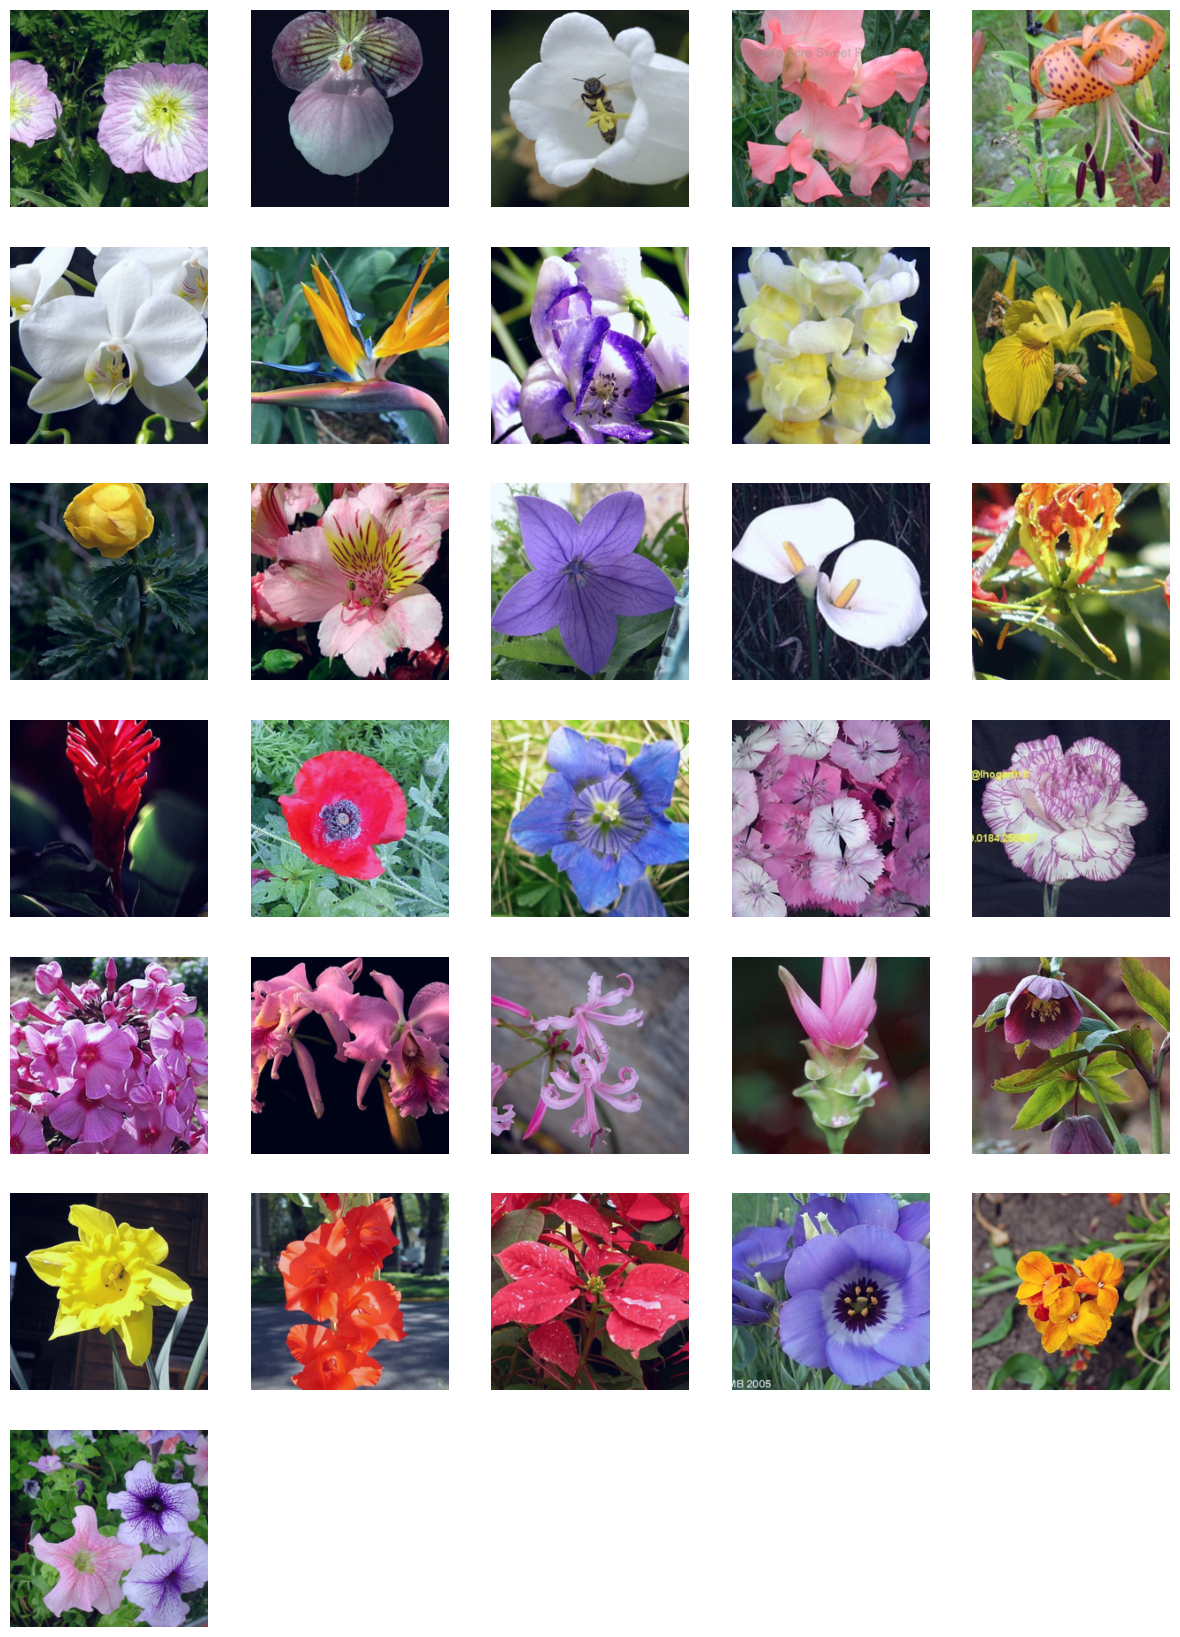

In [115]:
show_images(res[0].values(), n_cols=5)

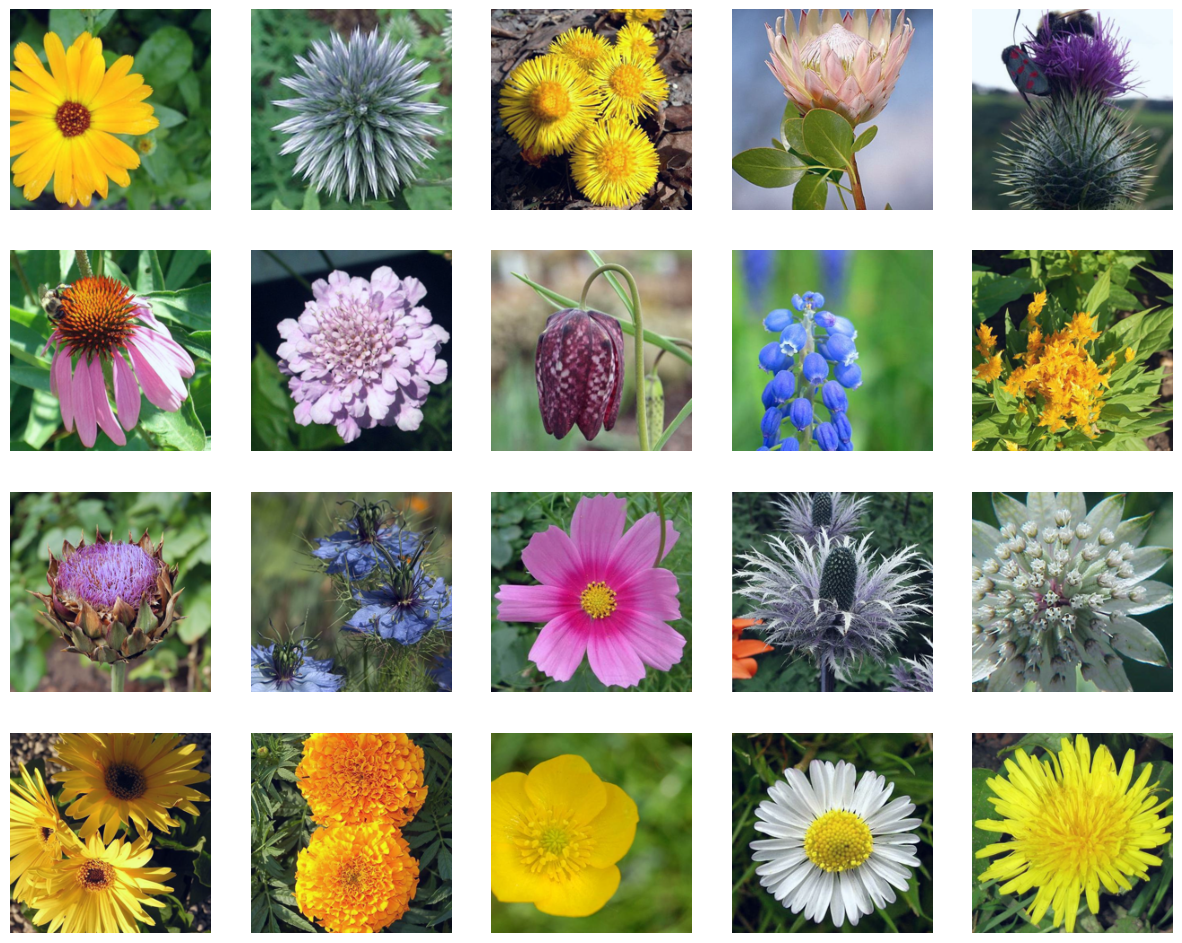

In [116]:
show_images(res[1].values(), n_cols=5)